In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet import preprocess_input

In [3]:
# Constants
INIT_LR = 1e-4
EPOCHS = 20
BS = 32


In [4]:

# Directory containing the data
DIRECTORY = r'C:\Users\aisho\OneDrive\Desktop\data'
CATEGORIES = ['fake', 'real']


In [5]:
# Data loading and preprocessing
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)  # Preprocessing specific to MobileNet
        data.append(image)
        labels.append(category)


C:\Users\aisho\anaconda3\envs\tf_new\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
# Convert labels to one-hot encoded format
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)


In [7]:
# Convert data and labels to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
# Split data into training and testing sets
trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)


In [9]:
# Data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [10]:
# Load pre-trained MobileNet model without the top (fully connected) layers
baseModel = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Construct the head of the model to be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

17225924/17225924 [==============================] - 12s 1us/step


In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [11]:
# Freeze the base model layers
for layer in baseModel.layers:
    layer.trainable = False

In [12]:
# Compile the model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# Train the model
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)


C:\Users\aisho\anaconda3\envs\tf_new\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
164/164 [==============================] - 185s 1s/step - loss: 0.6483 - accuracy: 0.6797 - val_loss: 0.5092 - val_accuracy: 0.7412
Epoch 2/20
164/164 [==============================] - 148s 897ms/step - loss: 0.5350 - accuracy: 0.7417
Epoch 3/20
164/164 [==============================] - 170s 1s/step - loss: 0.4787 - accuracy: 0.7844
Epoch 4/20
164/164 [==============================] - 158s 960ms/step - loss: 0.4491 - accuracy: 0.8039
Epoch 5/20
164/164 [==============================] - 173s 1s/step - loss: 0.4156 - accuracy: 0.8172
Epoch 6/20
164/164 [==============================] - 159s 967ms/step - loss: 0.3856 - accuracy: 0.8369
Epoch 7/20
164/164 [==============================] - 167s 1s/step - loss: 0.3722 - accuracy: 0.8399
Epoch 8/20
164/164 [==============================] - 169s 1s/step - loss: 0.3590 - accuracy: 0.8432
Epoch 9/20
164/164 [==============================] - 170s 1s/step - loss: 0.3336 - accuracy: 0.8591
Epoch 10/20
164/164 [===================

In [13]:
# Evaluate the model
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
true_labels = np.argmax(testY, axis=1)


42/42 [==============================] - 42s 958ms/step


In [14]:
# Print classification report
print(classification_report(true_labels, predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

        fake       0.89      0.95      0.92       468
        real       0.97      0.93      0.95       846

    accuracy                           0.94      1314
   macro avg       0.93      0.94      0.94      1314
weighted avg       0.94      0.94      0.94      1314



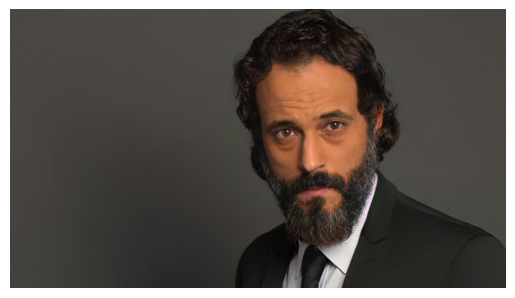

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load and display the image
image_path = r"C:\Users\aisho\OneDrive\Desktop\elaosboa68425.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

In [32]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input

# Load and preprocess the image
image_path = r"C:\Users\aisho\OneDrive\Desktop\elaosboa68425.jpg"
image = load_img(image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = preprocess_input(image_array.reshape(1, 224, 224, 3))

# Make predictions
predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions, axis=1)

# Convert the predicted index to class label using LabelBinarizer
predicted_class_label = lb.classes_[predicted_class_index[0]]

print(f"The predicted class is: {predicted_class_label}")

1/1 [==============================] - 0s 45ms/step
The predicted class is: real
